In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import csv
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse import lil_matrix

In [2]:

class LidarEnhancedVO:
    def __init__(self, image_folder, lidar_ref_path, known_altitude, K, dt=2.0):
        self.K = K
        self.known_altitude = known_altitude
        
        # Initialize ORB with your parameters
        self.orb = cv2.ORB_create(nfeatures=5000, scaleFactor=1.2, nlevels=8)
        
        # FLANN matcher parameters from your implementation
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
        
        # Load and process LiDAR reference
        self.lidar_ref = cv2.imread(lidar_ref_path, cv2.IMREAD_GRAYSCALE)
        if self.lidar_ref is None:
            raise ValueError(f"Could not load LiDAR reference: {lidar_ref_path}")
        self.lidar_ref = self.enhance_contrast(self.lidar_ref)
        self.lidar_kp, self.lidar_desc = self.orb.detectAndCompute(self.lidar_ref, None)
        
        # Initialize Kalman Filter states
        self.init_kalman(dt)
        
        # Load and preprocess images
        self.load_images(image_folder)
        
        # Initialize trajectory storage
        self.trajectory = [np.zeros(3)]
        self.all_descriptors = [self.descriptors[0]]
        # Initialize pose tracking
        self.R_total = np.eye(3)
        self.t_total = np.zeros((3, 1))
        
    def detect_loop_closures(self, distance_threshold=5.0, similarity_threshold=0.6):
        """Detect loop closures in the trajectory"""
        loop_closures = []
        trajectory_array = np.array(self.trajectory)
        
        nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn.fit(trajectory_array)
        
        for i in range(len(trajectory_array)):
            distances, indices = nn.kneighbors([trajectory_array[i]])
            for j, distance in zip(indices[0], distances[0]):
                if j > i + 10 and distance < distance_threshold:  # Avoid consecutive frames
                    # Check descriptor similarity
                    matches = self.flann.knnMatch(self.all_descriptors[i], 
                                                self.all_descriptors[j], k=2)
                    good_matches = []
                    for match in matches:
                        if len(match) == 2:
                            m, n = match
                            if m.distance < 0.68 * n.distance:
                                good_matches.append(m)
                    
                    if len(good_matches) / len(matches) > similarity_threshold:
                        loop_closures.append((i, j))
        
        return loop_closures
        
    def init_kalman(self, dt):
        self.x_kalman = np.zeros(9)  # [x, y, z, vx, vy, vz, roll, pitch, yaw]
        self.P_kalman = np.eye(9)
        self.Q_kalman = np.eye(9) * 1e-5
        self.R_kalman = np.eye(3) * 0.01
        
        self.F_kalman = np.eye(9)
        self.F_kalman[0, 3] = self.F_kalman[1, 4] = self.F_kalman[2, 5] = dt
        
        self.H_kalman = np.zeros((3, 9))
        self.H_kalman[0, 0] = self.H_kalman[1, 1] = self.H_kalman[2, 2] = 1
    
    @staticmethod
    def enhance_contrast(image):
        clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
        return clahe.apply(image)

    def create_pose_graph(self, loop_closures):
        """Create pose graph with loop closure constraints"""
        g = nx.Graph()
        
        # Add sequential edges
        for i in range(len(self.trajectory) - 1):
            g.add_edge(i, i+1, weight=1.0)
        
        # Add loop closure edges
        for i, j in loop_closures:
            g.add_edge(i, j, weight=0.1)  # Lower weight for loop closures
        
        return g

    def optimize_pose_graph(self, trajectory):
        """Optimize the pose graph"""
        n = len(trajectory)
        
        def objective(x):
            residuals = []
            poses = x.reshape(-1, 3)
            
            # Sequential constraints
            for i in range(len(poses) - 1):
                residuals.append((poses[i+1] - poses[i]) * 1.0)  # Weight for sequential
            
            # Loop closure constraints
            for i, j in self.loop_closures:
                residuals.append((poses[j] - poses[i]) * 0.1)  # Weight for loop closures
            
            return np.concatenate(residuals)
        
        # Optimize
        x0 = trajectory.flatten()
        res = least_squares(objective, x0)
        return res.x.reshape(-1, 3)
    
    def load_images(self, image_folder):
        image_files = sorted([f for f in os.listdir(image_folder) 
                            if f.endswith(('.jpg', '.png'))])
        
        self.images = []
        self.gray_images = []
        self.keypoints = []
        self.descriptors = []
        
        for image_file in image_files:
            img_path = os.path.join(image_folder, image_file)
            img = cv2.imread(img_path)
            gray_img = self.enhance_contrast(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
            
            self.images.append(img)
            self.gray_images.append(gray_img)
            
            kp, desc = self.orb.detectAndCompute(gray_img, None)
            self.keypoints.append(kp)
            self.descriptors.append(desc)
    
    def match_with_lidar(self, frame_desc):
        """Match current frame with LiDAR reference"""
        matches = self.flann.knnMatch(frame_desc, self.lidar_desc, k=2)
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.6 * n.distance:
                    good_matches.append(m)
        return good_matches
    
    def estimate_pose(self, p1, p2):
        """Estimate relative pose with Essential matrix refinement"""
        E, mask = cv2.findEssentialMat(p1, p2, self.K, method=cv2.RANSAC, 
                                     prob=0.999, threshold=0.5)
        E_refined = self.refine_E(E, p1, p2)
        _, R, t, mask = cv2.recoverPose(E_refined, p1, p2, self.K)
        return R, t, mask
    
    def refine_E(self, E, p1, p2):
        """Refine Essential matrix using your existing method"""
        def objective(E_vec):
            E_mat = E_vec.reshape(3, 3)
            p1_norm = cv2.undistortPoints(p1.reshape(-1, 1, 2), self.K, None).reshape(-1, 2)
            p2_norm = cv2.undistortPoints(p2.reshape(-1, 1, 2), self.K, None).reshape(-1, 2)
            error = 0
            for i in range(len(p1_norm)):
                p1_homogeneous = np.append(p1_norm[i], 1)
                p2_homogeneous = np.append(p2_norm[i], 1)
                error += np.abs(np.dot(p2_homogeneous, np.dot(E_mat, p1_homogeneous)))
            return error
        
        result = minimize(objective, E.flatten(), method='Nelder-Mead')
        return result.x.reshape(3, 3)
    
    def process_frame(self, i, last_keyframe_index):
        """Process a single frame with both consecutive and LiDAR matching"""
        if not self.is_keyframe(self.keypoints[i], self.keypoints[last_keyframe_index]):
            return None, last_keyframe_index
            
        # Match with previous keyframe
        matches = self.flann.knnMatch(self.descriptors[last_keyframe_index], 
                                    self.descriptors[i], k=2)
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.6 * n.distance:
                    good_matches.append(m)
                    
        if len(good_matches) > 10:
            # Get matching points
            p1 = np.float32([self.keypoints[last_keyframe_index][m.queryIdx].pt 
                            for m in good_matches])
            p2 = np.float32([self.keypoints[i][m.trainIdx].pt 
                            for m in good_matches])
            
            # Estimate pose from consecutive frames
            R_cons, t_cons, mask = self.estimate_pose(p1, p2)
            
            # Match with LiDAR reference
            lidar_matches = self.match_with_lidar(self.descriptors[i])
            
            if len(lidar_matches) > 10:
                # Get matching points for LiDAR
                p_frame = np.float32([self.keypoints[i][m.queryIdx].pt 
                                    for m in lidar_matches])
                p_lidar = np.float32([self.lidar_kp[m.trainIdx].pt 
                                    for m in lidar_matches])
                
                # Estimate pose relative to LiDAR
                R_lidar, t_lidar, _ = self.estimate_pose(p_frame, p_lidar)
                
                # Combine estimates (weighted average based on match confidence)
                w_cons = len(good_matches) / (len(good_matches) + len(lidar_matches))
                w_lidar = len(lidar_matches) / (len(good_matches) + len(lidar_matches))
                
                R = (w_cons * R_cons + w_lidar * R_lidar)
                t = (w_cons * t_cons + w_lidar * t_lidar)
            else:
                R, t = R_cons, t_cons
            
            # Apply Kalman filter
            z_kalman = t.flatten()
            x_pred = self.F_kalman @ self.x_kalman
            P_pred = self.F_kalman @ self.P_kalman @ self.F_kalman.T + self.Q_kalman
            
            y_kalman = z_kalman - self.H_kalman @ x_pred
            S_kalman = self.H_kalman @ P_pred @ self.H_kalman.T + self.R_kalman
            K_kalman = P_pred @ self.H_kalman.T @ np.linalg.inv(S_kalman)
            
            self.x_kalman = x_pred + K_kalman @ y_kalman
            self.P_kalman = (np.eye(len(self.P_kalman)) - K_kalman @ self.H_kalman) @ P_pred
            
            return (R, t, self.x_kalman[:3]), i
        
        return None, last_keyframe_index
    
    def optimize_trajectory(self):
        """Optimize trajectory using loop closure detection"""
        self.loop_closures = self.detect_loop_closures()
        if self.loop_closures:
            print(f"Loop closures detected: {self.loop_closures}")
            pose_graph = self.create_pose_graph(self.loop_closures)
            optimized_trajectory = self.optimize_pose_graph(np.array(self.trajectory))
            scaled_trajectory = self.scale_trajectory_constant_altitude(optimized_trajectory)
            self.trajectory = list(scaled_trajectory)
            
            # Update total transformation
            if len(self.trajectory) > 1:
                direction = self.trajectory[-1] - self.trajectory[-2]
                R_update, _ = cv2.Rodrigues(direction)
                self.R_total = R_update @ self.R_total
                self.t_total = self.trajectory[-1].reshape(3, 1)
    
    def run(self):
        """Run the complete VO pipeline"""
        last_keyframe_index = 0
        
        for i in range(1, len(self.images)):
            result, last_keyframe_index = self.process_frame(i, last_keyframe_index)
            
            if result is not None:
                R, t, refined_position = result
                self.R_total = R @ self.R_total
                self.t_total = R @ self.t_total + t
                
                self.trajectory.append(refined_position)
                self.all_descriptors.append(self.descriptors[i])
                
                # Perform loop closure and optimization periodically
                if len(self.trajectory) % 20 == 0:
                    self.optimize_trajectory()
        
        # Final scaling
        final_trajectory = np.array(self.trajectory)
        return self.scale_trajectory_constant_altitude(final_trajectory)

    def scale_trajectory_constant_altitude(self, trajectory):

        avg_z = np.mean(trajectory[:, 2])
        scale_factor = self.known_altitude / avg_z if avg_z != 0 else 1
        scaled_trajectory = trajectory * scale_factor
        scaled_trajectory[:, 2] = self.known_altitude
        return scaled_trajectory

    def visualize_trajectory_on_lidar(self, save_path=None):
        lidar_viz = cv2.cvtColor(self.lidar_ref, cv2.COLOR_GRAY2BGR)
        
        # Get trajectory points
        trajectory = np.array(self.trajectory)
        
        # Find trajectory bounds
        min_x, max_x = trajectory[:, 0].min(), trajectory[:, 0].max()
        min_y, max_y = trajectory[:, 1].min(), trajectory[:, 1].max()
        
        # Get image dimensions
        img_height, img_width = self.lidar_ref.shape[:2]
        
        # Transform trajectory points to image coordinates
        trajectory_img = []
        for point in trajectory:
            # Normalize coordinates to image space
            x_img = int(((point[0] - min_x) / (max_x - min_x)) * (img_width - 20) + 10)
            y_img = int(((point[1] - min_y) / (max_y - min_y)) * (img_height - 20) + 10)
            trajectory_img.append([x_img, y_img])
        
        trajectory_img = np.array(trajectory_img)
        
        # Draw trajectory
        # Draw lines between points
        for i in range(len(trajectory_img) - 1):
            pt1 = tuple(trajectory_img[i])
            pt2 = tuple(trajectory_img[i + 1])
            cv2.line(lidar_viz, pt1, pt2, (0, 255, 0), 2)
        
        # Draw points
        for i, point in enumerate(trajectory_img):
            # Start point in red
            if i == 0:
                cv2.circle(lidar_viz, tuple(point), 5, (0, 0, 255), -1)
            # End point in blue
            elif i == len(trajectory_img) - 1:
                cv2.circle(lidar_viz, tuple(point), 5, (255, 0, 0), -1)
            # Intermediate points in green
            else:
                cv2.circle(lidar_viz, tuple(point), 3, (0, 255, 0), -1)
        
        # Add legend
        legend_height = 60
        legend = np.ones((legend_height, img_width, 3), dtype=np.uint8) * 255
        
        # Draw legend items
        cv2.circle(legend, (30, 30), 5, (0, 0, 255), -1)
        cv2.putText(legend, "Start", (50, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        cv2.circle(legend, (130, 30), 5, (255, 0, 0), -1)
        cv2.putText(legend, "End", (150, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        cv2.circle(legend, (230, 30), 3, (0, 255, 0), -1)
        cv2.line(legend, (260, 30), (290, 30), (0, 255, 0), 2)
        cv2.putText(legend, "Trajectory", (300, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        
        # Combine visualization and legend
        final_viz = np.vstack((lidar_viz, legend))
        
        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(final_viz, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Trajectory Overlay on LiDAR Intensity Map')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            print(f"Visualization saved to {save_path}")
        
        plt.show()

    @staticmethod
    def is_keyframe(current_kp, last_keyframe_kp, min_matches=50):
        if len(last_keyframe_kp) == 0:
            return True
        return len(current_kp) >= min_matches

Path to images :  D:\Shwetabh D\support cases\WISPR\2025_02-07 WISPR - RESEPI-6C63BD-2025-02-05-20-50-51 - Orig\2025_02-07 WISPR - RESEPI-6C63BD-2025-02-05-20-50-51 - Orig\New folder
Path to lidar intensity image :  D:\Shwetabh D\support cases\WISPR\2025_02-07 WISPR - RESEPI-6C63BD-2025-02-05-20-50-51 - Orig\2025_02-07 WISPR - RESEPI-6C63BD-2025-02-05-20-50-51 - Orig\clouds\ppk_cloud_1.png


Visualization saved to trajectory_overlay.png


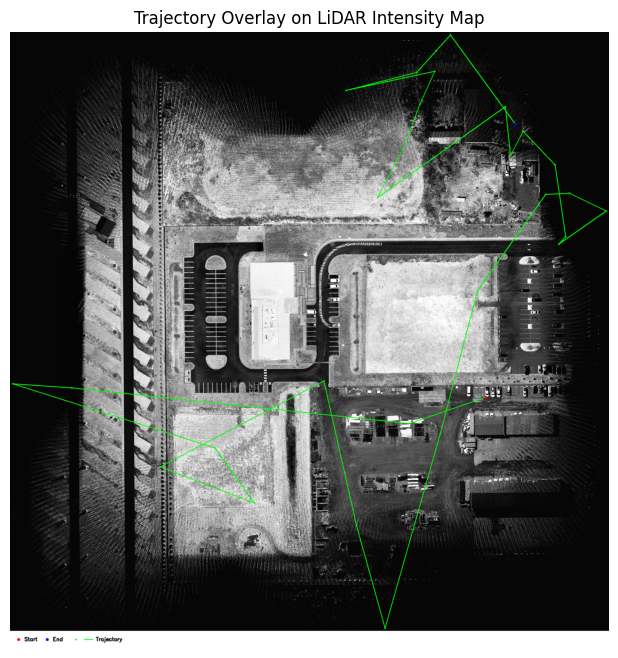

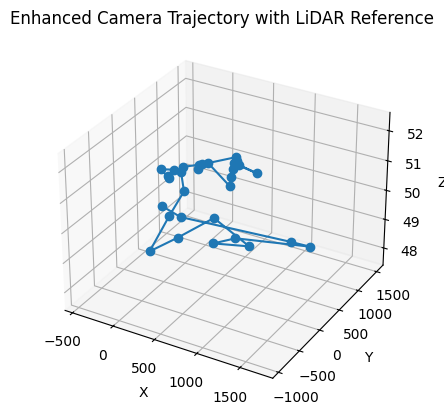

In [3]:

# Example usage
if __name__ == "__main__":
    # Camera matrix from your implementation
    K = np.array([
        [4085.11, 0, 3000],
        [0, 4102.56, 2000],
        [0, 0, 1]
    ])
    
    vo = LidarEnhancedVO(
        image_folder=input("Path to images : "),
        lidar_ref_path=input("Path to lidar intensity image : "),
        known_altitude=50.0,
        K=K
    )
    
    final_trajectory = vo.run()
    vo.visualize_trajectory_on_lidar(save_path="trajectory_overlay.png")  # Optional save_path
    # Visualization
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(final_trajectory[:, 0], final_trajectory[:, 1], final_trajectory[:, 2], marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Enhanced Camera Trajectory with LiDAR Reference')
    plt.show()
    
    # Save results
    np.savetxt('enhanced_trajectory.csv', final_trajectory, delimiter=',', 
               header='X,Y,Z', comments='')